# Imports

In [1]:
import pandas as pd
import numpy as np
from lib.helper import lmplot, Db
import matplotlib.pyplot as plt
import seaborn as sns

## Graphics

In [2]:
sns.set()

In [3]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

<Figure size 864x576 with 0 Axes>

# Config

In [4]:
base_path = ''
data_in   = f'{base_path}src'
data_out  = f'{base_path}db'
db_file = f'{data_out}/ussc.db'

In [5]:
db = Db(db_file)

In [6]:
csv = pd.read_csv(f'{data_in}/ussc_data.csv')
csv.columns = csv.columns.str.lower().str.replace(' ', '_')
csv['case_id'] = csv.filename.apply(lambda x: x.split('.')[0])

In [8]:
csv.head()

,index,filename,court,full_date,year,opinion_author,opinion,concur_1_author,concur_1,concur_2_author,...,concur_8,dissent_1_author,dissent_1,dissent_2_author,dissent_2,dissent_3_author,dissent_3,dissent_4_author,dissent_4,case_id
0,1,266_US_342.txt,USSC,"December 8, 1924",1924,TAFT,MR. CHIEF JUSTICE TAFT delivered the opinion o...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266_US_342
1,2,233_US_16.txt,USSC,"April 6, 1914",1914,WHITE_E,MR. CHIEF JUSTICE WHITE delivered the opinion ...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233_US_16
2,3,318_US_350.txt,USSC,"March 1, 1943",1943,FRANKFURTER,MR. JUSTICE FRANKFURTER delivered the opinion ...,NaN,NaN,NaN,...,NaN,REED,MR. JUSTICE REED dissents.\nXXX\n,NaN,NaN,NaN,NaN,NaN,NaN,318_US_350
3,4,70_US_37.txt,USSC,"January 15, 1866",1866,FIELD,Mr. Justice FIELD delivered the opinion of the...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70_US_37
4,5,460_US_428.txt,USSC,"March 22, 1983",1983,BLACKMUN,JUSTICE BLACKMUN delivered the opinion of the ...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,460_US_428


# Get column groups

In [9]:
concur_cols       = [x for x in csv.columns[csv.columns.str.match('^concur_\d$')]]
concur_auth_cols  = [x for x in csv.columns[csv.columns.str.match('^concur_\d_.+$')]]
dissent_cols      = [x for x in csv.columns[csv.columns.str.match('^dissent_\d$')]]
dissent_auth_cols = [x for x in csv.columns[csv.columns.str.match('^dissent_\d_.+$')]]
case_cols         = set(csv.columns) - set(concur_cols) - set(dissent_cols) - set(concur_auth_cols) - set(dissent_auth_cols) - {'opinion', 'opinion_author'}

# Create CASE table

In [10]:
db.add_table('CASE', csv[case_cols])

In [11]:
db.tables

['CASE']

In [12]:
# db.CASE = csv[case_cols]
db.CASE = db.CASE.join(db.CASE.case_id.str.split('_').to_frame()\
            .case_id.apply(pd.Series)[[0, 2]]\
            .rename(columns={0:'vol_num',2:'case_num'}))
db.CASE['vol_num'] = db.CASE.vol_num.astype('int')
db.CASE['case_num'] = db.CASE.case_num.astype('int')
db.CASE = db.CASE.set_index(['vol_num','case_num']).sort_index()
db.CASE = db.CASE.drop(['index','court','filename','case_id'], axis=1)

In [13]:
db.CASE

year          full_date
vol_num case_num                         
3       1         1794   February 7, 1794
        6         1794  February 18, 1794
        17        1795  February 20, 1795
        121       1795        AUGUST 1795
        171       1796      March 8, 1796
...                ...                ...
554     407       2008      June 25, 2008
        471       2008      June 26, 2008
        527       2008      June 26, 2008
        570       2008      June 26, 2008
        724       2008      June 26, 2008

[22115 rows x 2 columns]

In [14]:
db.CASE['justia_url'] = db.CASE.apply(lambda x: f"https://supreme.justia.com/cases/federal/us/{x.name[0]}/{x.name[1]}/", 1)

In [15]:
db.CASE.head()

year          full_date  \
vol_num case_num                            
3       1         1794   February 7, 1794   
        6         1794  February 18, 1794   
        17        1795  February 20, 1795   
        121       1795        AUGUST 1795   
        171       1796      March 8, 1796   

                                                         justia_url  
vol_num case_num                                                     
3       1          https://supreme.justia.com/cases/federal/us/3/1/  
        6          https://supreme.justia.com/cases/federal/us/3/6/  
        17        https://supreme.justia.com/cases/federal/us/3/17/  
        121       https://supreme.justia.com/cases/federal/us/3/...  
        171       https://supreme.justia.com/cases/federal/us/3/...

# Create CORPUS table (of opinions)

In [16]:
content_cols = ['opinion'] + concur_cols + dissent_cols
author_cols = ['opinion_author'] + concur_auth_cols + dissent_auth_cols
dfs = []
for x, y in zip(author_cols, content_cols):
    df = csv[['year','case_id', x, y]].copy()
    df = df.rename(columns={x:'author_id', y:'opinion'})
    df['position'] = x.split('_')[0]
    df = df.dropna()
    dfs.append(df)
db.add_table('CORPUS', pd.concat(dfs))
del(dfs)

In [17]:
db.CORPUS.head()

,year,case_id,author_id,opinion,position
0,1924,266_US_342,TAFT,MR. CHIEF JUSTICE TAFT delivered the opinion o...,opinion
1,1914,233_US_16,WHITE_E,MR. CHIEF JUSTICE WHITE delivered the opinion ...,opinion
2,1943,318_US_350,FRANKFURTER,MR. JUSTICE FRANKFURTER delivered the opinion ...,opinion
3,1866,70_US_37,FIELD,Mr. Justice FIELD delivered the opinion of the...,opinion
4,1983,460_US_428,BLACKMUN,JUSTICE BLACKMUN delivered the opinion of the ...,opinion


In [18]:
db.CORPUS['doc_len'] = db.CORPUS.opinion.str.len()
db.CORPUS[['vol_num','case_num']] = db.CORPUS.apply(lambda x: pd.Series(x.case_id.split('_')), 1)[[0,2]]
db.CORPUS.vol_num = db.CORPUS.vol_num.astype('int')
db.CORPUS.case_num = db.CORPUS.case_num.astype('int')

In [19]:
db.CORPUS.head()

,year,case_id,author_id,opinion,position,doc_len,vol_num,case_num
0,1924,266_US_342,TAFT,MR. CHIEF JUSTICE TAFT delivered the opinion o...,opinion,14556,266,342
1,1914,233_US_16,WHITE_E,MR. CHIEF JUSTICE WHITE delivered the opinion ...,opinion,9783,233,16
2,1943,318_US_350,FRANKFURTER,MR. JUSTICE FRANKFURTER delivered the opinion ...,opinion,10861,318,350
3,1866,70_US_37,FIELD,Mr. Justice FIELD delivered the opinion of the...,opinion,8867,70,37
4,1983,460_US_428,BLACKMUN,JUSTICE BLACKMUN delivered the opinion of the ...,opinion,34278,460,428


In [20]:
db.CORPUS = db.CORPUS.reset_index().set_index(['vol_num','case_num','author_id']).sort_index()
db.CORPUS = db.CORPUS[['year','position','opinion','doc_len']]

In [21]:
db.CORPUS

year position  \
vol_num case_num author_id                     
3       1        JAY           1794  opinion   
        6        JAY           1794  opinion   
        17       WILSON        1795  opinion   
        121      RUTLEDGE_J    1795  opinion   
        171      CHASE_SALMON  1796  opinion   
...                             ...      ...   
554     570      SCALIA        2008  opinion   
                 STEVENS       2008  dissent   
        724      ALITO         2008  opinion   
                 GINSBURG      2008   concur   
                 STEVENS       2008   concur   

                                                                         opinion  \
vol_num case_num author_id                                                         
3       1        JAY           The argument having continued for four days, t...   
        6        JAY           BY THE COURT: The Judges being decidedly of op...   
        17       WILSON        WILSON, Justice. The recognizance must be take...   
        121      RUTLEDGE_J    By the COURT: -- We have consulted together on...   
        171      CHASE_SALMON  THE COURT delivered their opinions seriatim in...   
...                                                                          ...   
554     570      SCALIA        Justice Scalia delivered the opinion of the Co...   
                 STEVENS       DISSENT BY: STEVENS; BREYER \nDISSENT \nJustic...   
        724      ALITO         Justice Alito delivered the opinion of the Cou...   
                 GINSBURG      Justice Ginsburg, with whom Justice Breyer joi...   
                 STEVENS       CONCUR BY: Stevens (In Part); Ginsburg (In Par...   

                               doc_len  
vol_num case_num author_id              
3       1        JAY              5712  
        6        JAY              2028  
        17       WILSON           2035  
        121      RUTLEDGE_J       8452  
        171      CHASE_SALMON     7826  
...                                ...  
554     570      SCALIA         107923  
                 STEVENS         62664  
        724      ALITO           40590  
                 GINSBURG         1253  
                 STEVENS         16154  

[34228 rows x 4 columns]

# Create AUTHOR table

NB: The `author_id` column is non-atomic.

In [22]:
# db.AUTHOR = db.CORPUS.reset_index()[['author_id','position']].value_counts().to_frame('n').unstack(fill_value=0)
db.add_table('AUTHOR', db.CORPUS.reset_index()[['author_id','position']].value_counts().to_frame('n').unstack(fill_value=0))
db.AUTHOR.columns = db.AUTHOR.columns.droplevel(0)
db.AUTHOR.columns.name = ''

In [23]:
db.AUTHOR['n_authors'] = db.AUTHOR.apply(lambda x: len(x.name.split()), 1)
db.AUTHOR['n_opinions'] = db.AUTHOR[['opinion','concur','dissent']].sum(1)

In [24]:
db.AUTHOR.head()

,concur,dissent,opinion,n_authors,n_opinions
author_id,,,,,
ALITO,10,13,17,1,40
BALDWIN,4,35,39,1,78
BARBOUR,0,3,17,1,20
BLACK,186,330,498,1,1014
BLACK CHIEF_JUSTICE DOUGLAS,1,0,0,3,1


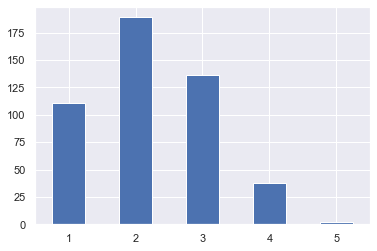

In [25]:
db.AUTHOR.n_authors.value_counts().sort_index().plot.bar(rot=0);

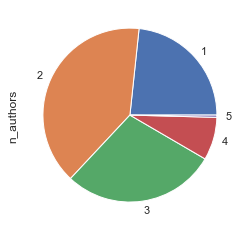

In [26]:
db.AUTHOR.n_authors.value_counts().sort_index().plot.pie();

# AUTHOR Success

An experimental way of measuring the success of a judge.

In [27]:
db.AUTHOR['success'] = np.log((((db.AUTHOR.concur + db.AUTHOR.opinion + 1) / (db.AUTHOR.dissent + 1)) * (db.AUTHOR.n_opinions + 2)))

In [28]:
db.AUTHOR.sort_values('success', ascending=False).head(20).style.background_gradient()

,concur,dissent,opinion,n_authors,n_opinions,success
author_id,,,,,,
PER CURIAM,0,0,574,2,574,12.710478
MARSHALL_J,0,4,394,1,398,10.360912
TAFT,2,2,251,1,255,9.987798
VANDEVANTER,2,7,359,1,368,9.725706
HOLMES,28,78,885,1,991,9.349113
FULLER,3,32,531,1,566,9.127881
HUGHES,6,19,393,1,418,9.035987
WHITE_E,33,70,686,1,789,8.989869
SWAYNE,4,11,293,1,308,8.948759


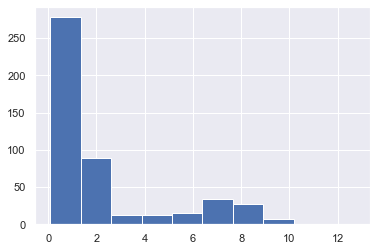

In [29]:
db.AUTHOR.success.hist();

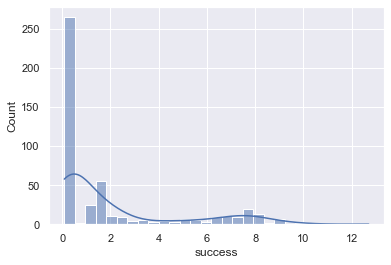

In [30]:
sns.histplot(data=db.AUTHOR, x='success', stat='count', kde=True);

# Add stat features to CASE

In [31]:
db.CASE['opinion_count'] = db.CORPUS.reset_index().groupby(['vol_num','case_num'])['position'].count().sort_values(ascending=False).to_frame()
db.CASE[['concur','dissent','opinion']] = db.CORPUS.groupby(['vol_num','case_num','position']).position.count().to_frame().unstack(fill_value=0)
db.CASE['doc_len_sum'] = db.CORPUS.groupby(['vol_num','case_num']).doc_len.sum()

In [32]:
db.CASE.describe().T

,count,mean,std,min,25%,50%,75%,max
year,22115.0,1923.464707,46.272354,1789.0,1896.0,1923.0,1961.0,2008.0
opinion_count,22115.0,1.548903,0.911670,1.0,1.0,1.0,2.0,9.0
concur,22115.0,0.205517,0.550059,0.0,0.0,0.0,0.0,6.0
dissent,22115.0,0.342211,0.612645,0.0,0.0,0.0,1.0,4.0
opinion,22115.0,1.001176,0.034269,1.0,1.0,1.0,1.0,2.0
doc_len_sum,22115.0,20002.719783,22836.842285,64.0,6793.0,13037.0,24939.5,631307.0


In [33]:
db.CASE.head()

year          full_date  \
vol_num case_num                            
3       1         1794   February 7, 1794   
        6         1794  February 18, 1794   
        17        1795  February 20, 1795   
        121       1795        AUGUST 1795   
        171       1796      March 8, 1796   

                                                         justia_url  \
vol_num case_num                                                      
3       1          https://supreme.justia.com/cases/federal/us/3/1/   
        6          https://supreme.justia.com/cases/federal/us/3/6/   
        17        https://supreme.justia.com/cases/federal/us/3/17/   
        121       https://supreme.justia.com/cases/federal/us/3/...   
        171       https://supreme.justia.com/cases/federal/us/3/...   

                  opinion_count  concur  dissent  opinion  doc_len_sum  
vol_num case_num                                                        
3       1                     1       0        0        1         5712  
        6                     1       0        0        1         2028  
        17                    1       0        0        1         2035  
        121                   1       0        0        1         8452  
        171                   5       3        1        1        30900

In [34]:
db.CASE.sort_values('opinion_count', ascending=False).head()

,,year,full_date,justia_url,opinion_count,concur,dissent,opinion,doc_len_sum
vol_num,case_num,,,,,,,,
60,393,1857,"March 5, 1857",https://supreme.justia.com/cases/federal/us/60...,9,6,2,1,631307
530,914,2000,"June 28, 2000",https://supreme.justia.com/cases/federal/us/53...,8,3,4,1,189109
343,579,1952,"June 2, 1952",https://supreme.justia.com/cases/federal/us/34...,7,5,1,1,168301
399,1,1970,"June 22, 1970",https://supreme.justia.com/cases/federal/us/39...,7,3,3,1,43105
433,425,1977,"June 28, 1977",https://supreme.justia.com/cases/federal/us/43...,7,4,2,1,202805


In [35]:
db.CASE.sort_values('doc_len_sum', ascending=False).head()

,,year,full_date,justia_url,opinion_count,concur,dissent,opinion,doc_len_sum
vol_num,case_num,,,,,,,,
60,393,1857,"March 5, 1857",https://supreme.justia.com/cases/federal/us/60...,9,6,2,1,631307
67,17,1863,"March 10, 1863",https://supreme.justia.com/cases/federal/us/67...,3,0,2,1,494184
367,1,1961,"June 5, 1961",https://supreme.justia.com/cases/federal/us/36...,5,0,4,1,329506
182,244,1901,"May 27, 1901",https://supreme.justia.com/cases/federal/us/18...,6,3,2,1,320133
79,457,1871,"May 1, 1871",https://supreme.justia.com/cases/federal/us/79...,5,1,3,1,317507


In [36]:
db.CASE['has_dissent'] = db.CASE.dissent.astype('bool').astype('int')

In [37]:
db.CASE.head()

year          full_date  \
vol_num case_num                            
3       1         1794   February 7, 1794   
        6         1794  February 18, 1794   
        17        1795  February 20, 1795   
        121       1795        AUGUST 1795   
        171       1796      March 8, 1796   

                                                         justia_url  \
vol_num case_num                                                      
3       1          https://supreme.justia.com/cases/federal/us/3/1/   
        6          https://supreme.justia.com/cases/federal/us/3/6/   
        17        https://supreme.justia.com/cases/federal/us/3/17/   
        121       https://supreme.justia.com/cases/federal/us/3/...   
        171       https://supreme.justia.com/cases/federal/us/3/...   

                  opinion_count  concur  dissent  opinion  doc_len_sum  \
vol_num case_num                                                         
3       1                     1       0        0        1         5712   
        6                     1       0        0        1         2028   
        17                    1       0        0        1         2035   
        121                   1       0        0        1         8452   
        171                   5       3        1        1        30900   

                  has_dissent  
vol_num case_num               
3       1                   0  
        6                   0  
        17                  0  
        121                 0  
        171                 1

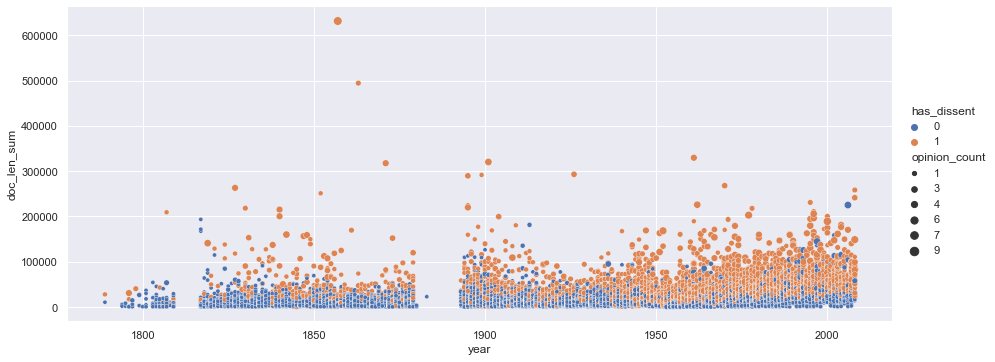

In [38]:
sns.relplot(data=db.CASE.reset_index(), 
            x='year', 
            y='doc_len_sum',            
            hue='has_dissent', 
            size='opinion_count',
            aspect=2.5);

# Look at CASE volume over time

In [39]:
# db.YEAR = db.CORPUS.groupby(['year']).doc_len.sum().to_frame('doc_len_sum')
db.add_table('YEAR', db.CORPUS.groupby(['year']).doc_len.sum().to_frame('doc_len_sum'))
db.YEAR['doc_len_mean'] = db.CORPUS.groupby(['year']).doc_len.mean()
db.YEAR['opinion_count'] = db.CORPUS.groupby(['year']).opinion.count()

In [40]:
db.YEAR.head()

,doc_len_sum,doc_len_mean,opinion_count
year,,,
1789,38585,12861.666667,3
1794,7740,3870.000000,2
1795,10487,5243.500000,2
1796,51193,5119.300000,10
1797,21407,5351.750000,4


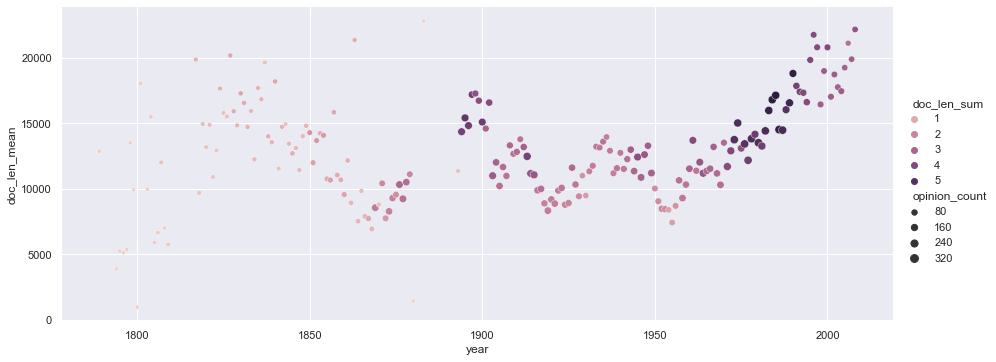

In [41]:
sns.relplot(data=db.YEAR.reset_index(), x='year', y='doc_len_mean', size='opinion_count', hue='doc_len_sum', aspect=2.5);

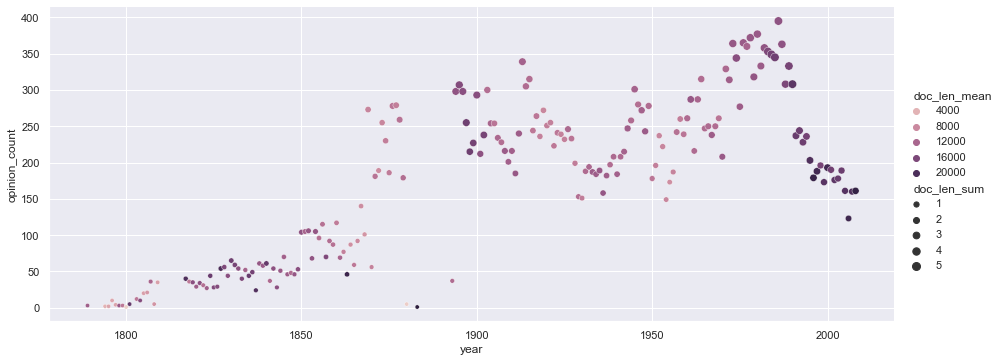

In [42]:
sns.relplot(data=db.YEAR.reset_index(), x='year', y='opinion_count', hue='doc_len_mean', size='doc_len_sum', aspect=2.5);

In [43]:
P = lmplot(db.YEAR.reset_index()).set_order(6).set_x('year');

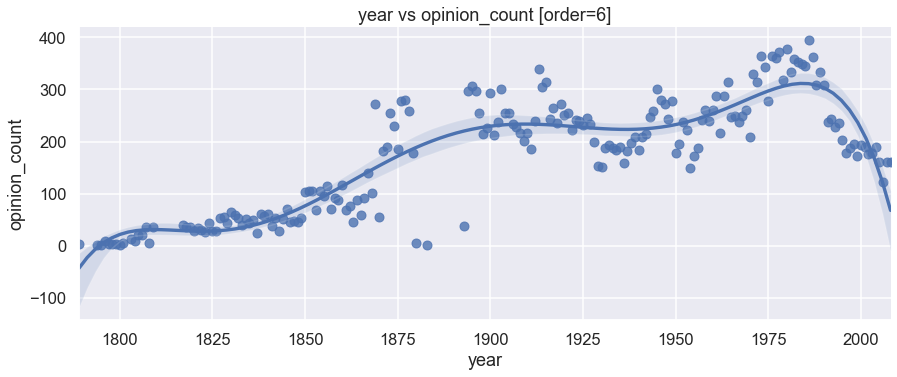

In [44]:
P.set_y('opinion_count').plot()

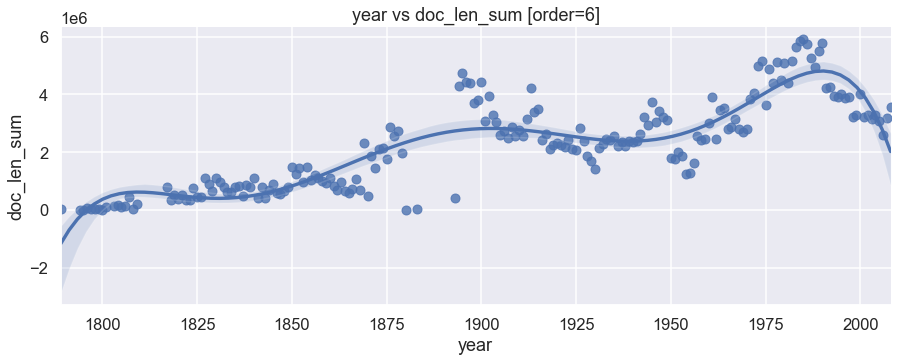

In [45]:
P.set_y('doc_len_sum').plot()

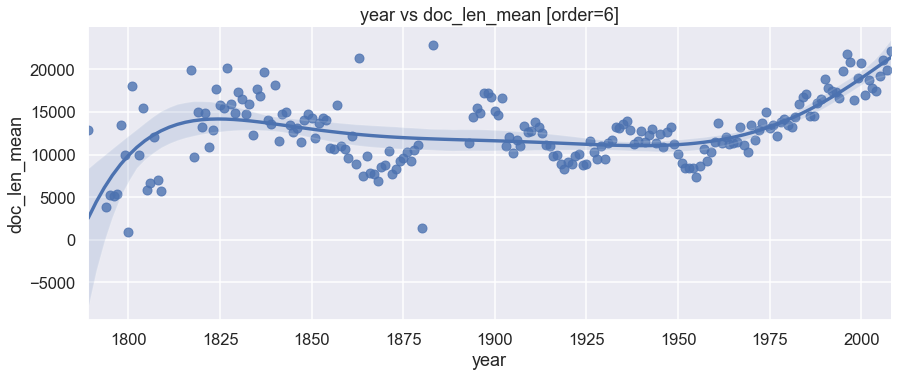

In [46]:
P.set_y('doc_len_mean').plot()

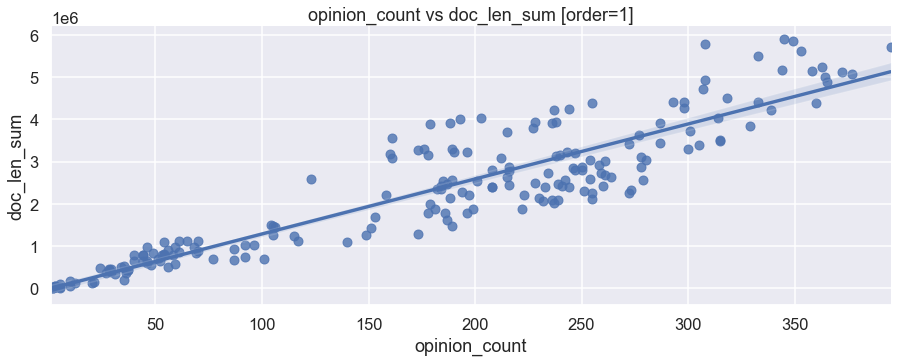

In [47]:
P.set_x('opinion_count').set_y('doc_len_sum').set_order(1).plot()

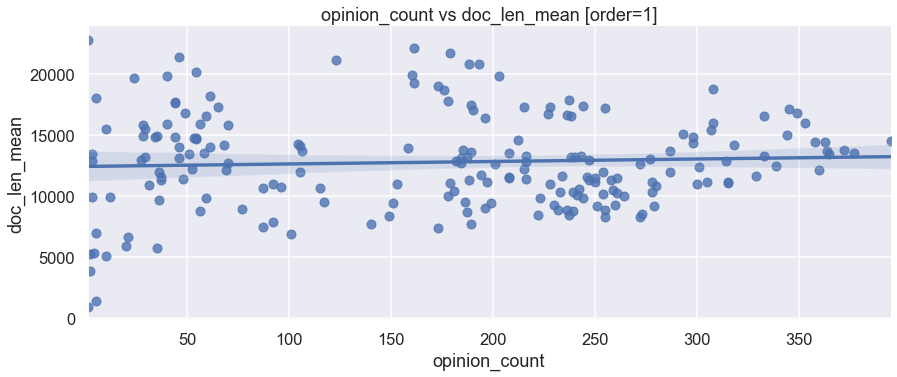

In [48]:
P.set_x('opinion_count').set_y('doc_len_mean').plot()

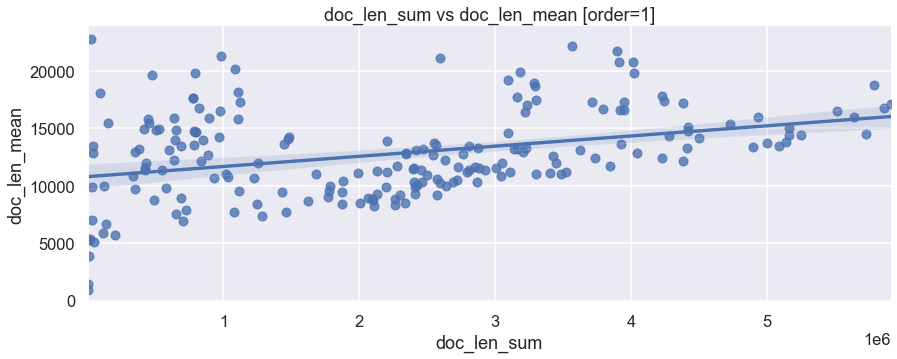

In [49]:
P.set_x('doc_len_sum').set_y('doc_len_mean').set_order(1).plot()

# Consolidate data by opinion

Keep those with both opinion and dissent.

In [50]:
M = db.CORPUS.groupby(['vol_num','case_num','position']).opinion.apply(lambda x: ' '.join(x)).to_frame().sort_index()

In [51]:
M.head()

opinion
vol_num case_num position                                                   
3       1        opinion   The argument having continued for four days, t...
        6        opinion   BY THE COURT: The Judges being decidedly of op...
        17       opinion   WILSON, Justice. The recognizance must be take...
        121      opinion   By the COURT: -- We have consulted together on...
        171      concur    IREDELL. Justice. -- I agree in opinion with m...

In [52]:
M1 = M.unstack()
M1.columns = M1.columns.droplevel(0)

In [53]:
M1.head()

position                                                     concur  \
vol_num case_num                                                      
3       1                                                       NaN   
        6                                                       NaN   
        17                                                      NaN   
        121                                                     NaN   
        171       IREDELL. Justice. -- I agree in opinion with m...   

position                                                    dissent  \
vol_num case_num                                                      
3       1                                                       NaN   
        6                                                       NaN   
        17                                                      NaN   
        121                                                     NaN   
        171       DISSENT BY: CUSHING\nCUSHING, Justice. As I ha...   

position                                                    opinion  
vol_num case_num                                                     
3       1         The argument having continued for four days, t...  
        6         BY THE COURT: The Judges being decidedly of op...  
        17        WILSON, Justice. The recognizance must be take...  
        121       By the COURT: -- We have consulted together on...  
        171       THE COURT delivered their opinions seriatim in...

In [54]:
# M2 = M1[['opinion','dissent']].stack().to_frame('doc_content')

In [55]:
# db.CORPUS_COMPRESSED = M1[(~M1.dissent.isna()) & (~M1.opinion.isna())][['opinion','dissent']].stack().to_frame('doc_content')

In [56]:
db.add_table('CORPUS_COMPRESSED', M1[(~M1.dissent.isna()) & (~M1.opinion.isna())][['opinion','dissent']].stack().to_frame('doc_content'))

In [57]:
db.CORPUS_COMPRESSED

doc_content
vol_num case_num position                                                   
3       171      opinion   THE COURT delivered their opinions seriatim in...
                 dissent   DISSENT BY: CUSHING\nCUSHING, Justice. As I ha...
        321      opinion   ELSWORTH, Chief Justice. The question, how far...
                 dissent   DISSENT BY: WILSON\nWILSON, Justice. I conside...
        386      opinion   CHASE, Justice. The decision of one question d...
...                                                                      ...
554     471      dissent   DISSENT BY: Stevens (In Part); Ginsburg (In Pa...
        527      opinion   Justice Scalia delivered the opinion of the Co...
                 dissent   DISSENT BY: Stevens \nDISSENT \nJustice Steven...
        570      opinion   Justice Scalia delivered the opinion of the Co...
                 dissent   Justice Breyer, with whom Justice Stevens, Jus...

[12348 rows x 1 columns]

In [58]:
db.CORPUS_COMPRESSED['doc_len'] = db.CORPUS_COMPRESSED.doc_content.str.len()

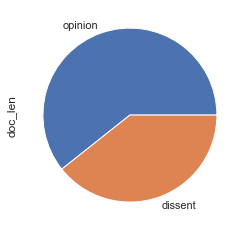

In [59]:
db.CORPUS_COMPRESSED.groupby('position').doc_len.mean().plot.pie();

# Export

In [60]:
db.save_all_tables()

Saving CASE
Saving CORPUS
Saving AUTHOR
Saving YEAR
Saving CORPUS_COMPRESSED
